In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load the dataset
try:
    df = pd.read_csv("cleaned_project_data.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found. Please ensure the file is in the correct directory.")
    # Exiting the script if the file is not found
    exit()

Dataset loaded successfully.


In [3]:
training_columns = [
    'PatientAge', 'PatientHasPosGp', 'PartenerHasPosGp', 'bmi', 'conception',
    'First degree relative with following medical conditions', 'PreviouslyDiagnosedMedicalConditions',
    'Number of Previous Childbirths after 28 Weeks', 'Outcome of Previous Pregnancies (Select all that apply):',
    'Mode of Delivery in Previous Pregnancies', 'History of Ruptured Uterus',
    'Number of Abortions (Births before 28 Weeks)', 'Interval from Last Pregnancy (in years)',
    'Previous history of Intrauterine Growth Restriction (IUGR)',
    'Any other Antenatal, Postnatal, or Delivery Complications both fetal and maternal',
    'If responded "Yes" in previous question, then please specify',
    'Gestational Age (GA) (in weeks)', 'Labor Pains currently',
    'Watery Vaginal Discharge currently', 'Bleeding/Spotting currently',
    'Reduced Fetal Movement (FM) currently', 'Mental Health Symptoms',
    'Other Symptoms (Select all that apply)',
    'Medicines in Use currently',
    'Previous Medicines Record (used for long term or frequently taken):',
    'Number of Cesarean Sections (C-sections)',
    'Number of ERPC (Evacuation of Retained Products of Conception)',
    'Previous history of PPH (Postpartum Hemorrhage) Exploration',
    'Any Anesthesia Complication previously',
    'Pallor', 'Jaundice', 'Thyroid enlarged', 'Edema', 'Coarse facial hair',
    'Systolic B.P', 'Diastolic BP', 'Pulse in full 1 minute',
    'Respiratory rate in full 1 minute', 'Temp. ( armpit for 2 ) in *F',
    'Per abdominal examination : Fundal height in weeks',
    'Per abdominal examination: Lie', 'Per abdominal examination: Presentation',
    'Per speculum examination', 'Per speculum examination (If Yes, specify findings)',
    'Per vaginal examination',
    'Per vaginal examination (If Yes, specify findings)',
    # 'Neonatal Apgar Score:(1 Minute)', 'Neonatal Apgar Score:(5 Minute)',
    'Mode_of_delivery2', 'Antenatal_Peripartum_Maternal_Complications',
    # 'Neonatal__Fetal_Complications',
    'Postnatal_Symptoms',
    'Postnatal_Examination',
    'History of any abdominal or pelvic surgery',
    'Any Uterine Surgery previously (Other than Cesarean Section)'
]

target_column = 'Postnatal_Maternal_Complications'

In [4]:
required_columns = training_columns + [target_column]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing from the dataset: {missing_columns}")
    # Exiting the script if required columns are not found
    exit()

In [5]:
print("\n--- Initial Data Exploration ---")
print(f"Total number of rows: {df.shape[0]}")
print("\nUnique values per column:")
for col in training_columns:
    print(f"  {col}: {df[col].nunique()} unique values")
# Print unique values for the single target column
print(f"  {target_column}: {df[target_column].nunique()} unique values")


--- Initial Data Exploration ---
Total number of rows: 10560

Unique values per column:
  PatientAge: 34 unique values
  PatientHasPosGp: 13 unique values
  PartenerHasPosGp: 16 unique values
  bmi: 239 unique values
  conception: 4 unique values
  First degree relative with following medical conditions: 56 unique values
  PreviouslyDiagnosedMedicalConditions: 48 unique values
  Number of Previous Childbirths after 28 Weeks: 11 unique values
  Outcome of Previous Pregnancies (Select all that apply):: 40 unique values
  Mode of Delivery in Previous Pregnancies: 24 unique values
  History of Ruptured Uterus: 2 unique values
  Number of Abortions (Births before 28 Weeks): 7 unique values
  Interval from Last Pregnancy (in years): 12 unique values
  Previous history of Intrauterine Growth Restriction (IUGR): 3 unique values
  Any other Antenatal, Postnatal, or Delivery Complications both fetal and maternal: 4 unique values
  If responded "Yes" in previous question, then please specify: 12

In [6]:
print("\nDropping rows with missing values...")
initial_rows = df.shape[0]
df.dropna(subset=[target_column], inplace=True)
df.dropna(subset=training_columns, inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing values.")
print(f"Remaining rows: {rows_after_drop}")


Dropping rows with missing values...
Dropped 707 rows with missing values.
Remaining rows: 9853


In [7]:
# Set the minimum threshold for classes to be included
min_sample_threshold = 10

In [8]:
# Get the value counts of the target variable
class_counts = df[target_column].value_counts()
print("\nInitial class distribution of the target variable:")
print(class_counts)
class_counts.count()


Initial class distribution of the target variable:
Postnatal_Maternal_Complications
not delivered yet                                                 4579
no complication                                                   3349
sepsis                                                             308
hypertension                                                       193
acute hepatic failure                                              181
infected wound                                                     120
chemotherapy                                                       102
deep vein thrombosis                                                93
sepsis and icu admission                                            77
postpartum hemorrhage                                               76
icu admission                                                       62
cardiac failure and icu admission                                   53
postpartum depression                                          

np.int64(48)

In [9]:
classes_to_sample = class_counts[class_counts >= min_sample_threshold].index
print(f"\nFound {len(classes_to_sample)} classes with a count >= 10:")
print(list(classes_to_sample))


Found 36 classes with a count >= 10:
['not delivered yet', 'no complication', 'sepsis', 'hypertension', 'acute hepatic failure', 'infected wound', 'chemotherapy', 'deep vein thrombosis', 'sepsis and icu admission', 'postpartum hemorrhage', 'icu admission', 'cardiac failure and icu admission', 'postpartum depression', 'postpartum hemorrhage and sock and icu admission', 'puerperal pyrexia', 'anemia', 'acute mastitis', 'sepsis and acute renal failure', 'postpartum eclampsia', 'laparotomy and shock and icu admission', 'not delivered yet and ecv', 'no compl', 'acute hepatitis e', 'normal fndings', 'postpartum hemorrhage, wound hematoma, sock and icu admission', 'postpartum hemorrhage and icu admission', 'acute renal failure and icu admission', 'urinary tract infection', 'postpartum hemorrahge and sepsis', 'chemotherapy and sepsis', 'eclampsia and icu admission', 'deep vein thrombosis and sepsis', 'icu admission and cardiac failure', 'sepsis and acute renal failure and icu admission', 'infe

In [10]:
balanced_df = pd.DataFrame()

# Sample from each of the selected classes
if not classes_to_sample.empty:
    for cls in classes_to_sample:
        # Take ALL samples from this class (no sampling)
        class_samples = df[df[target_column] == cls]
        balanced_df = pd.concat([balanced_df, class_samples], ignore_index=True)

    print(f"\nSuccessfully created a balanced dataset with {balanced_df.shape[0]} samples.")
    # Update the main dataframe to the new, balanced one
    df = balanced_df
else:
    print("\nNo classes found with a count >= 10. Skipping class balancing.")


Successfully created a balanced dataset with 9824 samples.


In [11]:
print("\nDropping rows with missing feature values from the new dataset...")
initial_rows = df.shape[0]
df.dropna(subset=training_columns, inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing feature values.")
print(f"Remaining rows: {rows_after_drop}")


Dropping rows with missing feature values from the new dataset...
Dropped 0 rows with missing feature values.
Remaining rows: 9824


In [12]:
X = df[training_columns]
y = df[target_column]

In [13]:
print(f"\nBefore cleaning target column: {y.nunique()} unique values")
# Convert to string, lowercase, and remove leading/trailing whitespace
y = y.astype(str).str.lower().str.strip()
print(f"After cleaning target column: {y.nunique()} unique values")
print("New unique values in target column:")
print(y.unique())


Before cleaning target column: 36 unique values
After cleaning target column: 36 unique values
New unique values in target column:
['not delivered yet' 'no complication' 'sepsis' 'hypertension'
 'acute hepatic failure' 'infected wound' 'chemotherapy'
 'deep vein thrombosis' 'sepsis and icu admission' 'postpartum hemorrhage'
 'icu admission' 'cardiac failure and icu admission'
 'postpartum depression'
 'postpartum hemorrhage and sock and icu admission' 'puerperal pyrexia'
 'anemia' 'acute mastitis' 'sepsis and acute renal failure'
 'postpartum eclampsia' 'laparotomy and shock and icu admission'
 'not delivered yet and ecv' 'no compl' 'acute hepatitis e'
 'normal fndings'
 'postpartum hemorrhage, wound hematoma, sock and icu admission'
 'postpartum hemorrhage and icu admission'
 'acute renal failure and icu admission' 'urinary tract infection'
 'postpartum hemorrahge and sepsis' 'chemotherapy and sepsis'
 'eclampsia and icu admission' 'deep vein thrombosis and sepsis'
 'icu admission an

In [14]:
# Final check of y distribution
final_y_counts = y.value_counts()
print(f"\nFinal y distribution:")
print(final_y_counts)



Final y distribution:
Postnatal_Maternal_Complications
not delivered yet                                                4579
no complication                                                  3349
sepsis                                                            308
hypertension                                                      193
acute hepatic failure                                             181
infected wound                                                    120
chemotherapy                                                      102
deep vein thrombosis                                               93
sepsis and icu admission                                           77
postpartum hemorrhage                                              76
icu admission                                                      62
cardiac failure and icu admission                                  53
postpartum depression                                              49
postpartum hemorrhage and sock and

In [15]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

In [16]:
for col in categorical_features:
    # Use a safer method to convert to string and then lowercase
    X.loc[:, col] = X[col].astype(str).str.lower()

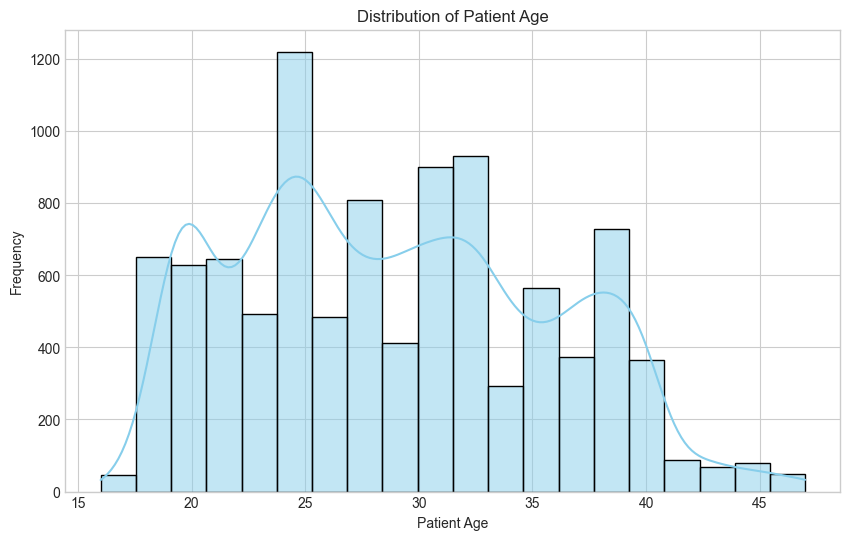

In [17]:
plt.style.use('seaborn-v0_8-whitegrid')

# Plot distribution of a numerical feature (e.g., PatientAge)
plt.figure(figsize=(10, 6))
sns.histplot(X['PatientAge'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\zainm\AppData\Local\Temp\ipykernel_26672\2514994627.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette='viridis', order=y.value_counts().index)


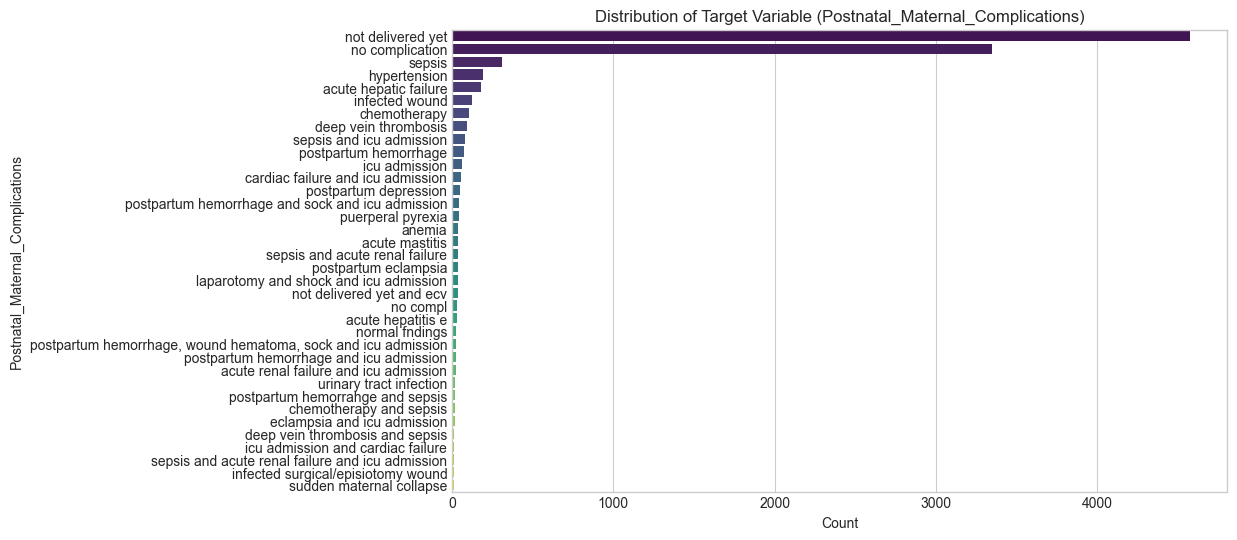

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(y=y, palette='viridis', order=y.value_counts().index)
plt.title('Distribution of Target Variable (Postnatal_Maternal_Complications)')
plt.xlabel('Count')
plt.ylabel('Postnatal_Maternal_Complications')
plt.show()

In [19]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nData split into training and testing sets.")


Data split into training and testing sets.


In [21]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


Starting model training and evaluation...

Training Logistic Regression...
Logistic Regression Accuracy: 0.9152
Classification Report for Logistic Regression:
                                                               precision    recall  f1-score   support

                                        acute hepatic failure       1.00      1.00      1.00        54
                                            acute hepatitis e       1.00      1.00      1.00         8
                                               acute mastitis       1.00      1.00      1.00        11
                        acute renal failure and icu admission       0.00      0.00      0.00         7
                                                       anemia       1.00      0.83      0.91        12
                            cardiac failure and icu admission       0.94      0.94      0.94        16
                                                 chemotherapy       0.88      0.94      0.91        31
               

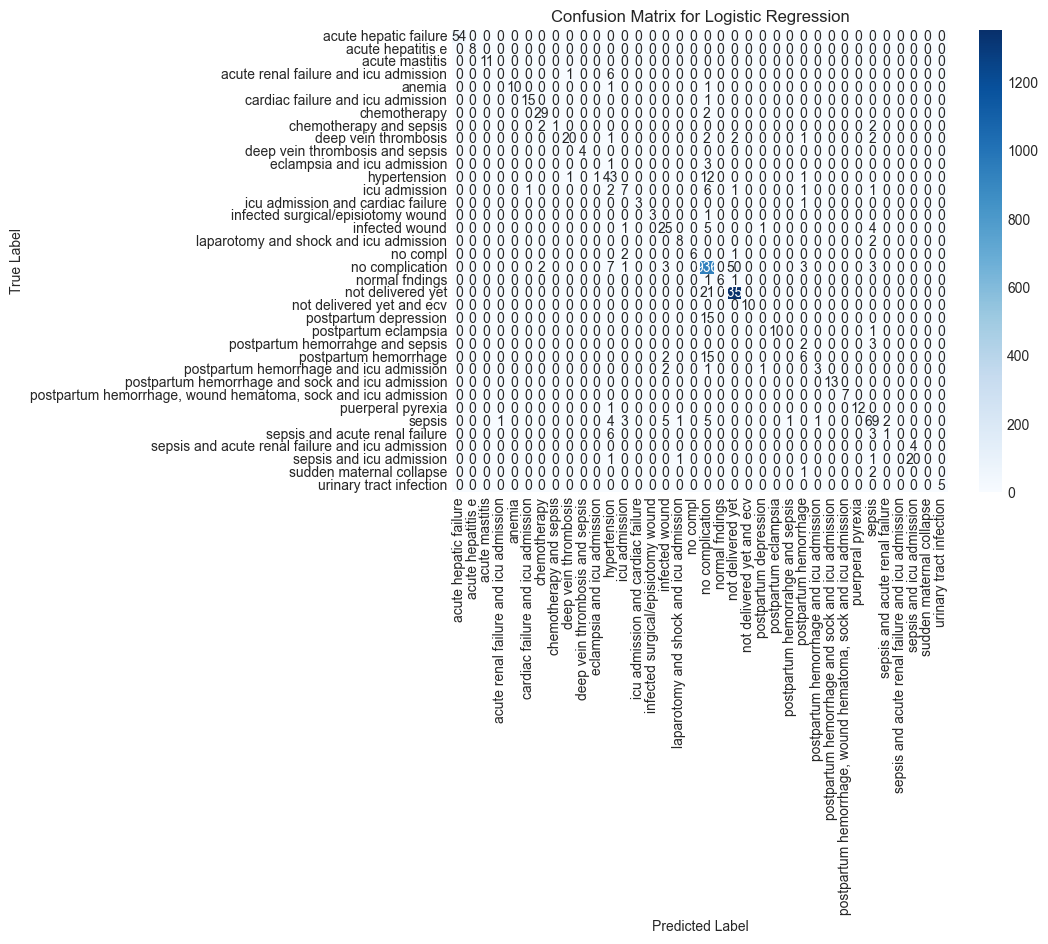


Training Random Forest...
Random Forest Accuracy: 0.8931
Classification Report for Random Forest:
                                                               precision    recall  f1-score   support

                                        acute hepatic failure       1.00      1.00      1.00        54
                                            acute hepatitis e       1.00      1.00      1.00         8
                                               acute mastitis       1.00      1.00      1.00        11
                        acute renal failure and icu admission       0.00      0.00      0.00         7
                                                       anemia       1.00      0.75      0.86        12
                            cardiac failure and icu admission       0.80      0.50      0.62        16
                                                 chemotherapy       0.83      0.94      0.88        31
                                      chemotherapy and sepsis       0.00    

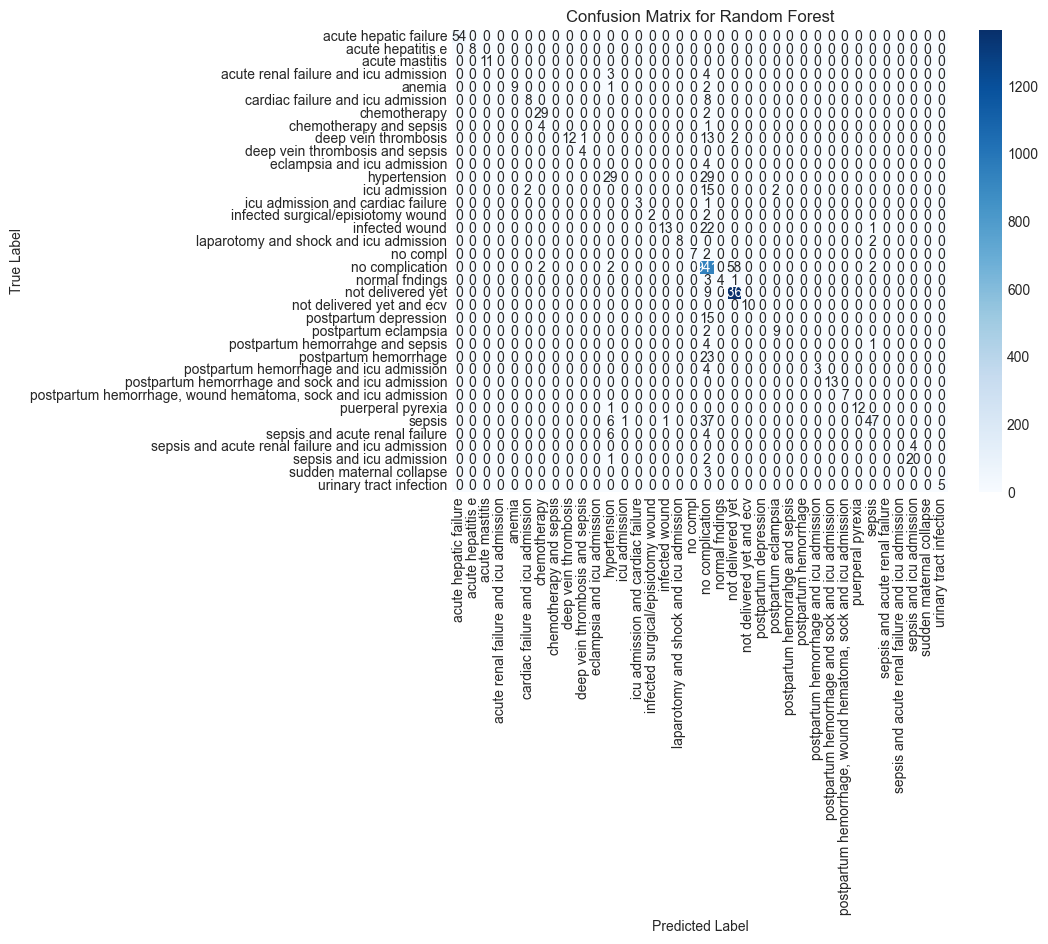


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9301
Classification Report for Gradient Boosting:
                                                               precision    recall  f1-score   support

                                        acute hepatic failure       1.00      1.00      1.00        54
                                            acute hepatitis e       1.00      1.00      1.00         8
                                               acute mastitis       1.00      1.00      1.00        11
                        acute renal failure and icu admission       0.25      0.14      0.18         7
                                                       anemia       1.00      0.92      0.96        12
                            cardiac failure and icu admission       0.92      0.75      0.83        16
                                                 chemotherapy       0.82      0.90      0.86        31
                                      chemotherapy and sepsis   

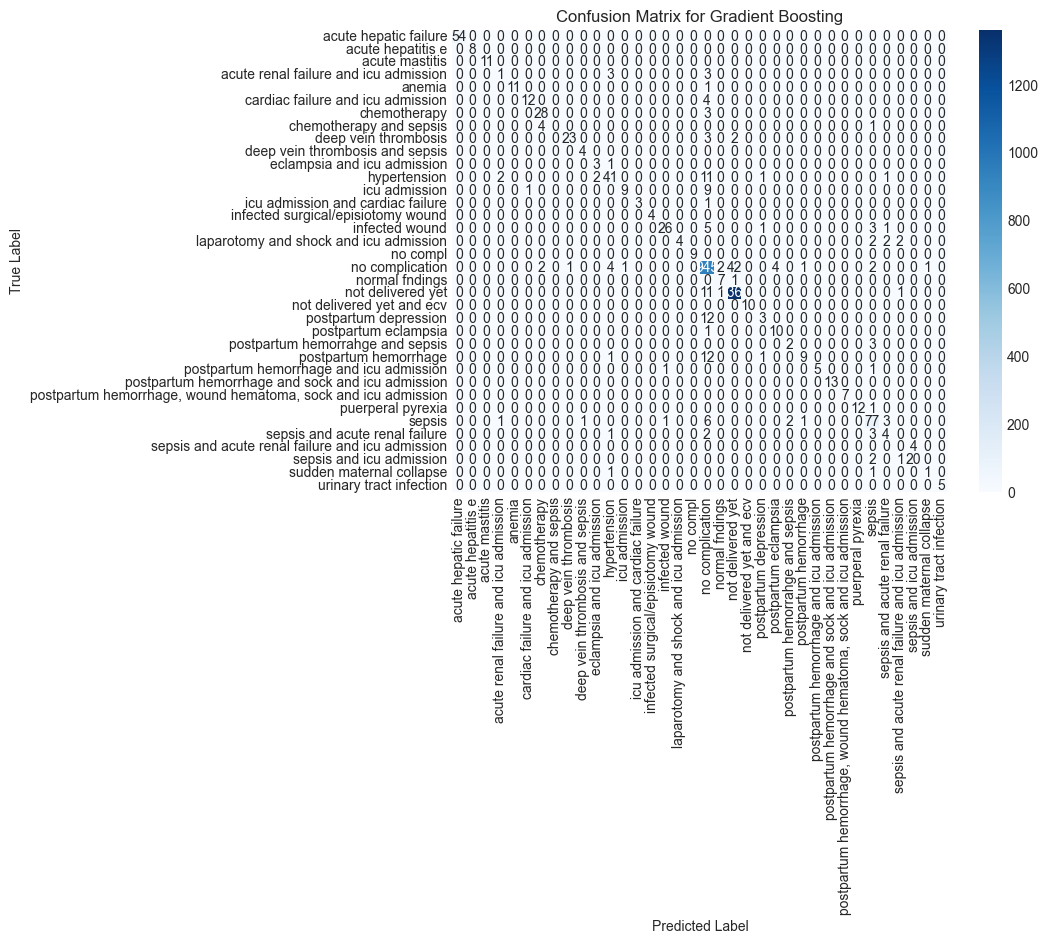

In [22]:

results = {}
pipelines = {} # Dictionary to store trained pipelines

print("\nStarting model training and evaluation...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create a full pipeline with the preprocessor and the model
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])
    
    # Train the model
    full_pipeline.fit(X_train, y_train)
    
    # Store the trained pipeline
    pipelines[name] = full_pipeline
    
    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:\n{report}")
    
    # Optional: Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

C:\Users\zainm\AppData\Local\Temp\ipykernel_26672\3829775270.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='deep')


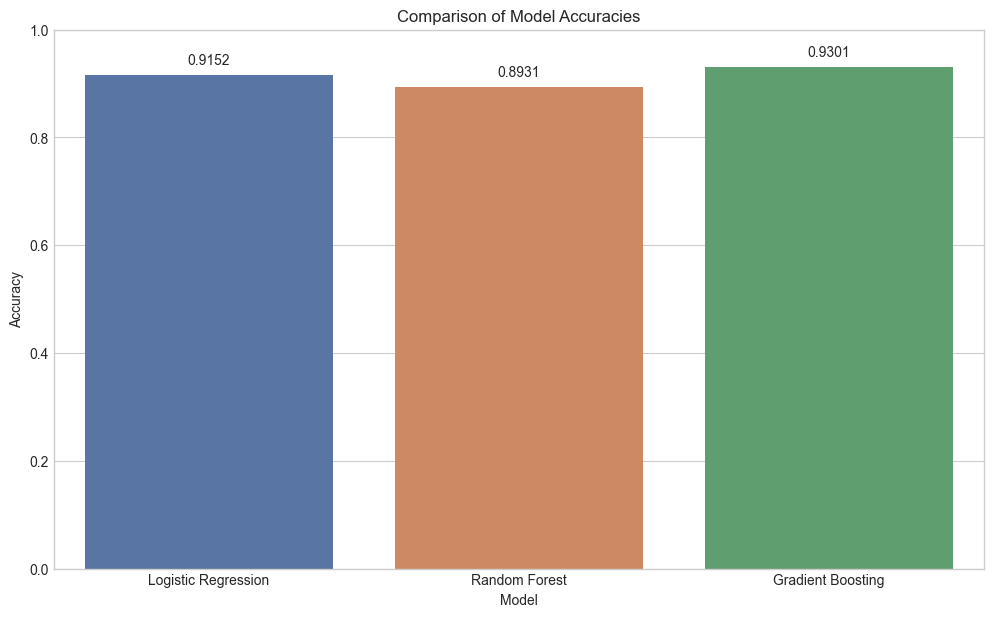

In [23]:
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(12, 7))
sns.barplot(x=model_names, y=accuracies, palette='deep')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()

In [24]:
# Find the best model and save it
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
best_pipeline = pipelines[best_model_name]

print(f"\n--- Final Result ---")
print(f"The best performing model is: {best_model_name}")
print(f"With an accuracy of: {best_model_accuracy:.4f}")


--- Final Result ---
The best performing model is: Gradient Boosting
With an accuracy of: 0.9301


In [25]:
model_filename = 'best_postnatal_complications_prediction_model.joblib'
try:
    joblib.dump(best_pipeline, model_filename)
    print(f"\nBest model saved to {model_filename}")
except Exception as e:
    print(f"\nError saving the model: {e}")


Best model saved to best_postnatal_complications_prediction_model.joblib
